In [1]:
# Python built-in module
import warnings

# Third-party modules
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, LeakyReLU
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from pathlib import Path

from typing import Tuple

# Set random seed and enable operation determinism
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Ignore warnings
warnings.filterwarnings("ignore")

2023-11-29 13:19:21.893370: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:19:21.955281: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 13:19:21.955322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 13:19:21.956717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 13:19:21.966749: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def prepare_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, StandardScaler]:
    # Drop the first column from the dataframe
    df.drop(1, axis=1, inplace=True)
    
    # Initialize a label encoder
    encoder = LabelEncoder()
    
    # Fit and transform the 34th column with the label encoder
    df[34] = encoder.fit_transform(df[34])
    
    # Separate the features (X) and the target variable (y)
    X = df.drop(34, axis=1)
    y = df[34]
    
    # Initialize a standard scaler
    scaler = StandardScaler()
    
    # Fit and transform the features with the standard scaler
    X = scaler.fit_transform(X)
    
    # Return the scaled features, the target variable, and the scaler
    return X, y, scaler

In [3]:
# Load the dataset
df = pd.read_csv('data/ionosphere.data', header=None)
# Prepare the dataset
X,y, scaler = prepare_data(df)
print(X.shape, y.shape)

(351, 33) (351,)


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42, shuffle=True)

In [5]:
@dataclass
class Params:
    input_dim: int = X.shape[1]  # Input dimension based on features
    output_dim: int = 1  # Output dimension (binary classification)
    dropout: float = 0.3  # Dropout rate for regularization
    learning_rate: float = 0.0001  # Learning rate for optimizer
    epochs: int = 200  # Number of training epochs
    batch_size: int = 64  # Batch size for training
    save_dir: str = Path('checkpoints')  # Directory to save model checkpoints
    save_path: str = save_dir/'model.h5'  # Path to save the model
    verbose: int = 1  # Verbosity mode

    # Create directory if it doesn't exist
    save_dir.mkdir(parents=True, exist_ok=True)

# Create an instance of Params
params = Params()

In [6]:
def create_model(input_size, hidden_size, num_classes, dropout_rate=0.3):
    # Initialize a Sequential model
    model = Sequential([
        # First hidden layer with 'hidden_size*2' neurons, and input dimensionality as 'input_size'
        Dense(hidden_size*2, input_dim=input_size,),
        # Apply LeakyReLU activation function
        LeakyReLU(),
        # Normalize the activations of the previous layer at each batch
        BatchNormalization(),
        
        # Second hidden layer with 'hidden_size*2' neurons
        Dense(hidden_size*2),
        # Apply LeakyReLU activation function
        LeakyReLU(),
        # Normalize the activations of the previous layer at each batch
        BatchNormalization(),
        
        # Third hidden layer with 'hidden_size' neurons
        Dense(hidden_size),
        # Apply LeakyReLU activation function
        LeakyReLU(),
        # Normalize the activations of the previous layer at each batch
        BatchNormalization(),
        
        # Apply dropout with rate 'dropout_rate' to prevent overfitting
        Dropout(dropout_rate),
        
        # Output layer with 'num_classes' neurons and linear activation function
        Dense(num_classes, activation='linear')
    ])
    
    # Return the constructed model
    return model

In [7]:
model = create_model(input_size = params.input_dim,hidden_size=20,num_classes=params.output_dim, dropout_rate=params.dropout)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                1360      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 40)                0         
                                                                 
 batch_normalization (Batch  (None, 40)                160       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 40)                160       
 chNormalization)                                       

In [8]:
# Binary Crossentropy loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=params.learning_rate)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=params.learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# Assign schedule to optimizer
optimizer.learning_rate = lr_schedule

# Metrics for training monitoring
metrics = ['accuracy', tf.keras.metrics.AUC()]

# Callback to save best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    str(params.save_path),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=params.verbose,)

# Callback for early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min',
    verbose=params.verbose,)

# Callback to reduce learning rate on plateau
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=params.verbose,)

# List of callbacks
callbacks = [early_stopping_cb, reduce_lr_cb, checkpoint_cb]

# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [9]:
# Fit the model
hist = model.fit(X_train, y_train, callbacks=callbacks, validation_data=(X_test, y_test), epochs=params.epochs, batch_size=params.batch_size)

Epoch 1/200
2/5 [===========>..................] - ETA: 1s - loss: 0.8260 - accuracy: 0.4375 - auc: 0.5201 
Epoch 1: val_loss improved from inf to 0.68657, saving model to checkpoints/model.h5
5/5 [==============================] - 4s 247ms/step - loss: 0.8849 - accuracy: 0.4144 - auc: 0.4811 - val_loss: 0.6866 - val_accuracy: 0.3977 - val_auc: 0.5279 - lr: 1.0000e-04
Epoch 2/200
1/5 [=====>........................] - ETA: 0s - loss: 0.9274 - accuracy: 0.4688 - auc: 0.4995
Epoch 2: val_loss improved from 0.68657 to 0.68428, saving model to checkpoints/model.h5
5/5 [==============================] - 0s 40ms/step - loss: 0.8896 - accuracy: 0.4449 - auc: 0.5163 - val_loss: 0.6843 - val_accuracy: 0.4091 - val_auc: 0.5460 - lr: 1.0000e-04
Epoch 3/200
1/5 [=====>........................] - ETA: 0s - loss: 0.9423 - accuracy: 0.4062 - auc: 0.4807
Epoch 3: val_loss improved from 0.68428 to 0.68160, saving model to checkpoints/model.h5
5/5 [==============================] - 0s 43ms/step - loss: 

Minimum training loss: 0.2093062400817871
Minimum validation loss: 0.22787486016750336


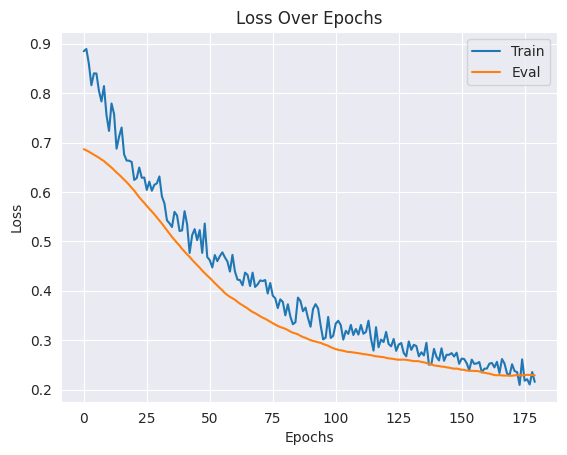

In [10]:
# Print the minimum loss values achieved during training and validation
print(f"Minimum training loss: {min(hist.history['loss'])}")
print(f"Minimum validation loss: {min(hist.history['val_loss'])}")

# Set the style of the plots
sns.set_style('darkgrid')

# Plot the training and validation loss over epochs
plt.plot(hist.history['loss'], label='Train')  # Training loss
plt.plot(hist.history['val_loss'], label='Eval')  # Validation loss

# Set the title and labels of the plot
plt.title('Loss Over Epochs')  # Title
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label

# Show the legend and the plot
plt.legend()
plt.show()

Maximum training accuracy: 0.9543726444244385
Maximum validation accuracy: 0.9545454382896423


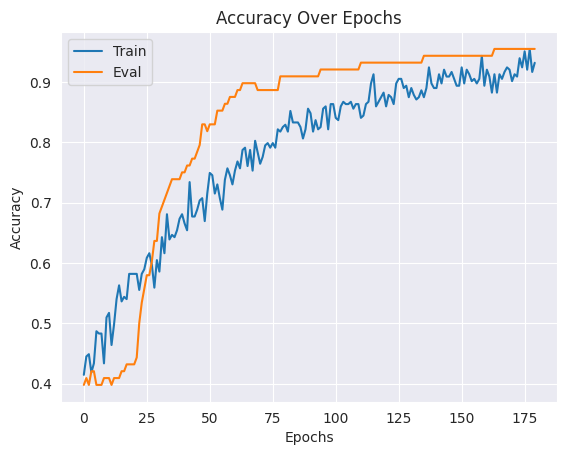

In [11]:
# Print the maximum accuracy values achieved during training and validation
print(f"Maximum training accuracy: {max(hist.history['accuracy'])}")
print(f"Maximum validation accuracy: {max(hist.history['val_accuracy'])}")

# Set the style of the plots
sns.set_style('darkgrid')

# Plot the training and validation accuracy over epochs
plt.plot(hist.history['accuracy'], label='Train')  # Training accuracy
plt.plot(hist.history['val_accuracy'], label='Eval')  # Validation accuracy

# Set the title and labels of the plot
plt.title('Accuracy Over Epochs')  # Title
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label

# Show the legend and the plot
plt.legend()
plt.show()

Maximum training AUC: 0.9803285598754883
Maximum validation AUC: 0.9500558972358704


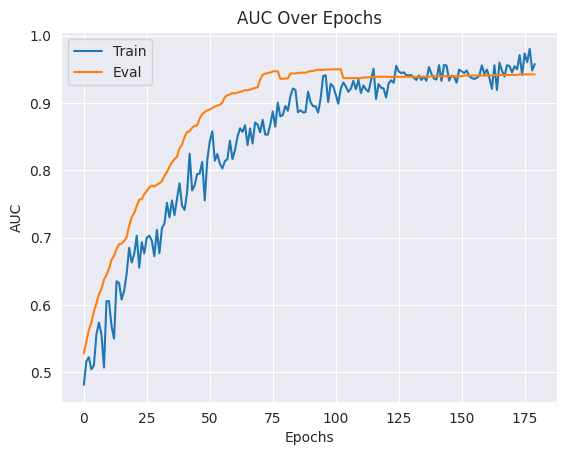

In [12]:
# Print the maximum AUC values achieved during training and validation
print(f"Maximum training AUC: {max(hist.history['auc'])}")
print(f"Maximum validation AUC: {max(hist.history['val_auc'])}")

# Set the style of the plots
sns.set_style('darkgrid')

# Plot the training and validation AUC over epochs
plt.plot(hist.history['auc'], label='Train')  # Training AUC
plt.plot(hist.history['val_auc'], label='Eval')  # Validation AUC

# Set the title and labels of the plot
plt.title('AUC Over Epochs')  # Title
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('AUC')  # Y-axis label

# Show the legend and the plot
plt.legend()
plt.show()

In [13]:
#make dataframe of metrics
metrics_df = pd.DataFrame.from_dict(hist.history)
#save metrics to csv
metrics_df.to_csv('metrics.csv', index=False)